In [18]:
import numpy as np
import pandas as pd
import os
import sys

# Add the directory containing the VotingModel to the Python path
sys.path.append(os.path.abspath('/Users/idrees/Code/govxs/'))
from util.voting_rules import mean_aggregation, median_aggregation, quadratic_aggregation

from model.VotingModel import VotingModel

def simulate_bribery_mean(model, target_project, desired_increase):
    num_voters, num_projects = model.voting_matrix.shape
    new_voting_matrix = model.voting_matrix.copy()
    original_voting_matrix=new_voting_matrix

    # Calculate the original allocation
    original_allocation = model.mean_aggregation()
    original_funds = original_allocation[target_project]

    # Calculate the target allocation
    target_funds = original_funds + desired_increase
    total_required_votes = target_funds * num_voters

    # Calculate the current votes for the target project
    current_votes = np.sum(new_voting_matrix[:, target_project])
    votes_needed = total_required_votes - current_votes

    bribery_cost = votes_needed
    
    return bribery_cost

def simulate_bribery_quadratic(model, target_project, desired_increase):
    num_voters, num_projects = model.voting_matrix.shape
    new_voting_matrix = model.voting_matrix.copy()

    # Calculate the original allocation
    original_allocation = model.quadratic_aggregation()
    original_funds = original_allocation[target_project]

    # Calculate the target allocation
    target_funds = original_funds + desired_increase
    total_required_votes = (target_funds * np.sum(original_allocation)) ** 0.5

    # Calculate the current votes for the target project
    current_votes = np.sum(new_voting_matrix[:, target_project] ** 2)
    votes_needed = total_required_votes - np.sqrt(current_votes)
    votes_needed = votes_needed ** 2

    bribery_cost = votes_needed
    
    
    return bribery_cost

def simulate_bribery_median(model, target_project, desired_increase):
    num_voters, num_projects = model.voting_matrix.shape
    new_voting_matrix = model.voting_matrix.copy()
    original_voting_matrix=new_voting_matrix

    # Calculate the original allocation
    original_allocation = model.median_aggregation()
    original_funds = original_allocation[target_project]

    # Calculate the target allocation
    target_funds = original_funds + desired_increase

    # Calculate the current median vote for the target project
    votes = new_voting_matrix[:, target_project]
    current_median_vote = np.median(votes)

    # Determine the new median vote required
    total_required_votes = target_funds * model.num_voters / model.total_op_tokens
    votes_needed = total_required_votes - current_median_vote
    

    bribery_cost = desired_increase

    return bribery_cost

def evaluate_bribery_impact(model, target_project, desired_increase):
    # Bribery impact for each aggregation method
    bribery_costs = {}
    for method in ["mean", "median", "quadratic"]:
        if method == "mean":
            bribery_cost = simulate_bribery_mean(model, target_project, desired_increase)
        elif method == "median":
            bribery_cost = simulate_bribery_median(model, target_project, desired_increase)
        elif method == "quadratic":
            bribery_cost = simulate_bribery_quadratic(model, target_project, desired_increase)
    
        bribery_costs[method + "_bribery_cost"] = bribery_cost

    return bribery_costs# Initialize the model
model = VotingModel(num_voters=144, num_projects=600, total_op_tokens=30e6)
model.step()

# Set parameters for bribery evaluation
target_project = 1
desired_increase = 10000  # Desired increase of 5M OP tokens

# Evaluate the impact of bribery
bribery_impact_df = (evaluate_bribery_impact(model, target_project, desired_increase))

In [19]:
bribery_impact_df

{'mean_bribery_cost': np.float64(1439999.9999999981),
 'median_bribery_cost': 10000,
 'quadratic_bribery_cost': np.float64(222599265712.29398)}

In [30]:
def run_simulation(num_rounds, num_voters, num_projects, total_op_tokens):
    results = []

    for i in range(num_rounds):
        # Initialize the model
        model = VotingModel(num_voters=num_voters, num_projects=num_projects, total_op_tokens=total_op_tokens)
        model.step()

        # Set parameters for bribery evaluation
        target_project = np.random.randint(0, num_projects)  # Randomly select a target project
        desired_increase = np.random.uniform(100, 1000000)  # Randomly set a desired increase between 5K and 10K OP tokens

        # Evaluate the impact of bribery
        bribery_costs = evaluate_bribery_impact(model, target_project, desired_increase)

        result = {
            "round": i + 1,
            "target_project": target_project,
            "desired_increase": desired_increase,
            "mean_bribery_cost": bribery_costs.get("mean_bribery_cost"),
            "median_bribery_cost": bribery_costs.get("median_bribery_cost"),
            "quadratic_bribery_cost": bribery_costs.get("quadratic_bribery_cost")
        }

        results.append(result)

    # Create a DataFrame from the results
    final_results = pd.DataFrame(results)
    return final_results

# Parameters for multiple simulations
num_rounds = 1000
num_voters = 144
num_projects = 600
total_op_tokens = 30e6

# Run the simulations
final_results = run_simulation(num_rounds, num_voters, num_projects, total_op_tokens)

# Display the results

/Users/idrees/Code/govxs/agents/VoterAgent.py:8: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


In [31]:
final_results

,round,target_project,desired_increase,mean_bribery_cost,median_bribery_cost,quadratic_bribery_cost
0,1,492,184918.812103,2.662831e+07,184918.812103,3.281597e+12
1,2,92,382027.533966,5.501196e+07,382027.533966,8.176732e+12
2,3,377,903506.522595,1.301049e+08,903506.522595,2.031941e+13
3,4,405,510523.109285,7.351533e+07,510523.109285,1.018799e+13
4,5,17,805688.821536,1.160192e+08,805688.821536,1.832099e+13
...,...,...,...,...,...,...
995,996,369,67043.806467,9.654308e+06,67043.806467,1.097143e+12
996,997,120,99766.807895,1.436642e+07,99766.807895,1.593290e+12
997,998,549,724240.824857,1.042907e+08,724240.824857,1.623499e+13
998,999,478,335932.230308,4.837424e+07,335932.230308,6.854511e+12


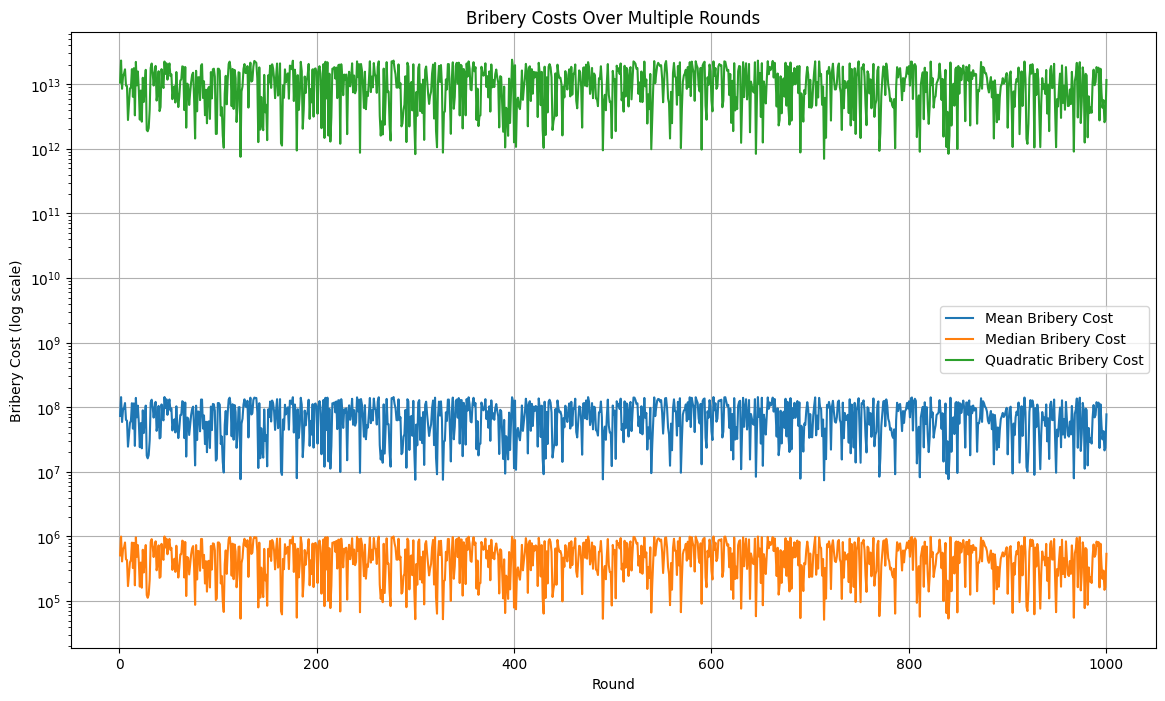

In [29]:
import matplotlib.pyplot as plt

# Plot the results with a logarithmic y-axis
def plot_bribery_costs(df):
    plt.figure(figsize=(14, 8))

    # Plot mean bribery cost
    plt.plot(df['round'], df['mean_bribery_cost'], label='Mean Bribery Cost')

    # Plot median bribery cost
    plt.plot(df['round'], df['median_bribery_cost'], label='Median Bribery Cost')

    # Plot quadratic bribery cost
    plt.plot(df['round'], df['quadratic_bribery_cost'], label='Quadratic Bribery Cost')

    plt.xlabel('Round')
    plt.ylabel('Bribery Cost (log scale)')
    plt.yscale('log')
    plt.title('Bribery Costs Over Multiple Rounds')
    plt.legend()
    plt.grid(True)
    plt.show()



# Plot the bribery costs
plot_bribery_costs(final_results)
